# **Imports**

Below are all the modules that we are going to need in this notebook.

In [1]:
# Common
import os
import keras
import numpy as np 
from glob import glob
from tqdm import tqdm 
import tensorflow as tf

# Data 
from keras.preprocessing.image import ImageDataGenerator

# Data VIz
import plotly.express as px
import matplotlib.pyplot as plt

# Model
from keras import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import load_model

# Transfer Learning
from tensorflow.keras.applications import Xception

# Callbacks 
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# **Data**

The foremost thing that we have to do is to **understand our data**.

In [2]:
# This is the main path to our data set.
root_path = '../input/yoga-posture-dataset'

# The folder names are our Classes
class_names = sorted(os.listdir(root_path))
class_names.remove('Poses.json')
n_classes = len(class_names)

print(f"Total Number of Classes : {n_classes}")
print(f"Classes : \n{class_names}")

Total Number of Classes : 47
Classes : 
['Adho Mukha Svanasana', 'Adho Mukha Vrksasana', 'Alanasana', 'Anjaneyasana', 'Ardha Chandrasana', 'Ardha Matsyendrasana', 'Ardha Navasana', 'Ardha Pincha Mayurasana', 'Ashta Chandrasana', 'Baddha Konasana', 'Bakasana', 'Balasana', 'Bitilasana', 'Camatkarasana', 'Dhanurasana', 'Eka Pada Rajakapotasana', 'Garudasana', 'Halasana', 'Hanumanasana', 'Malasana', 'Marjaryasana', 'Navasana', 'Padmasana', 'Parsva Virabhadrasana', 'Parsvottanasana', 'Paschimottanasana', 'Phalakasana', 'Pincha Mayurasana', 'Salamba Bhujangasana', 'Salamba Sarvangasana', 'Setu Bandha Sarvangasana', 'Sivasana', 'Supta Kapotasana', 'Trikonasana', 'Upavistha Konasana', 'Urdhva Dhanurasana', 'Urdhva Mukha Svsnssana', 'Ustrasana', 'Utkatasana', 'Uttanasana', 'Utthita Hasta Padangusthasana', 'Utthita Parsvakonasana', 'Vasisthasana', 'Virabhadrasana One', 'Virabhadrasana Three', 'Virabhadrasana Two', 'Vrksasana']


Before loading the images, we need to check the **class distribution**.

In [3]:
class_dis = [len(os.listdir(root_path + f"/{name}")) for name in class_names]
print(class_dis)

[74, 65, 18, 71, 59, 96, 13, 54, 12, 81, 84, 79, 94, 62, 54, 53, 85, 71, 41, 73, 56, 18, 77, 14, 43, 62, 66, 43, 62, 73, 66, 20, 13, 23, 17, 74, 69, 96, 81, 71, 64, 69, 80, 64, 69, 61, 68]


Let's understand more by **visualizing** this **class distribution**.

In [4]:
fig = px.pie(
    names=class_names,
    values=class_dis,
    title="Class Distribution",
)
fig.update_layout({'title':{
    'x':0.5
}})
fig.show()

In [5]:
fig = px.bar(
    x=class_names,
    y=class_dis,
    title="Class Distribution",
)
fig.update_layout({'title':{
    'x':0.5
}})
fig.show()

The **class distribution** is good, but **some classes** have **very low number of images**. This will affect our **final model** because for these **class predictions** will **not be as accurate**.

Let's load the **data set** using the **ImageDataGenerator**,

In [6]:
# Initialize data generator
data_gen = ImageDataGenerator(
    rotation_range=20,
    validation_split=0.2,
    rescale=1./255
)

# Load Data
train_ds = data_gen.flow_from_directory(root_path, target_size=(256,256), class_mode='binary', subset='training')
valid_ds = data_gen.flow_from_directory(root_path, target_size=(256,256), class_mode='binary', subset='validation')

Found 2227 images belonging to 47 classes.
Found 529 images belonging to 47 classes.


# **Data Visualization**

In [7]:
def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

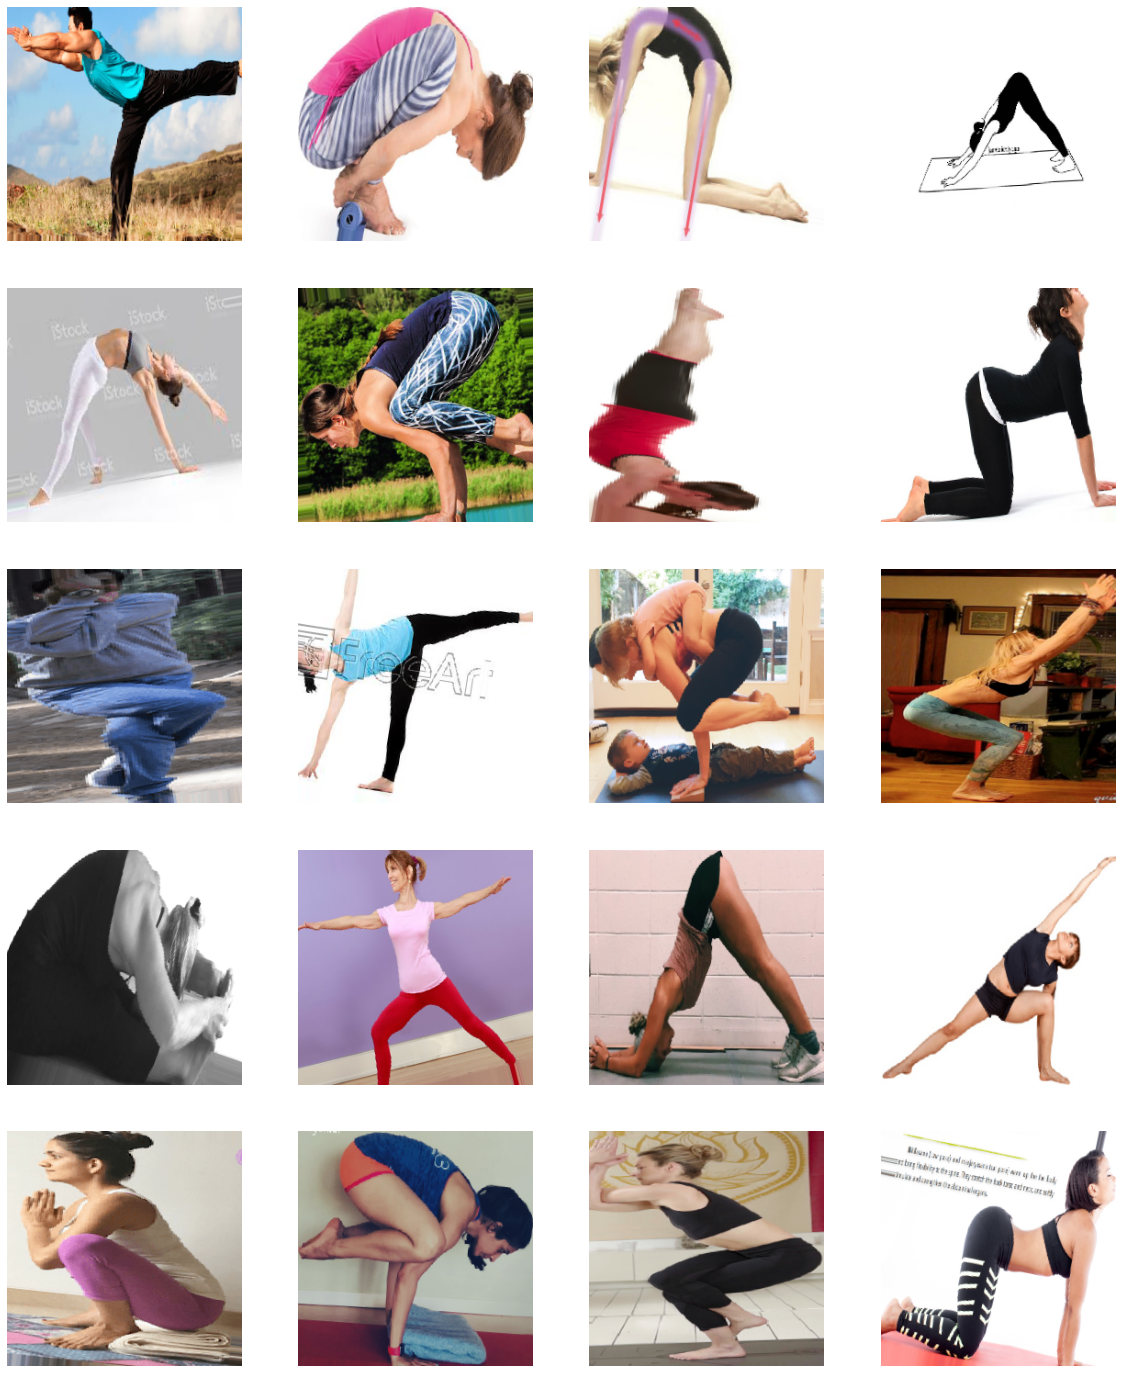

In [8]:
n = 1
plt.figure(figsize=(20,25))
for images, labels in train_ds:
    plt.subplot(5,4,n)
    show_image(images[n])
    n+=1
    if n>=21:
        break
plt.show()

# **Model**

The model is based on Transfer Learning approach, different models were tried like :

* **ResNet50**
* **ResNet50V2**
* **InceptionV3**
* **Xception** - Best Performance

In [9]:
# Loading Xception for TRansfer-Learning
base_model = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(256,256,3)
)
base_model.trainable=False

83697664/83683744 [==============================] - 3s 0us/step


In [10]:
# Model Architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
#     Dropout(0.4),
#     Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(n_classes, activation='softmax')
])

# Compiling Model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


# Callbacks
callbacks = [EarlyStopping(patience=3, restore_best_weights=True)]

In [11]:
# model.fit(
#     train_ds,
#     validation_data=valid_ds,
#     epochs=50,
#     callbacks=callbacks
# )

In [12]:
model = load_model('../input/yoga-posture-classification/Xception-YOGA-Pose-Estimation.h5')

The model took 40 Epochs to reach Training Accuracy of 66.68 % and a Validation Accuracy of 54.25%

# **Evaluation**

In [13]:
model.evaluate(valid_ds)

17/17 [==============================] - 57s 3s/step - loss: 1.3511 - accuracy: 0.6049


[1.35112464427948, 0.6049149632453918]

$Problem :$ 

* The model's performance drastically decreases once you apply **Data Augmentation**.

* But just think why would you click a bad picture during YOGA?

---
$Observation :$

* The **model starts** with **very low accuracy** and the accuracy generally **increases after 10 Epochs**, but it will **soon start overfitting the data**. 

* You can try out a different **Architecture**, that could help.

* The Model have a **training accuracy of above 70%**

**Thanks !!!**

---
**DeepNets**